In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
sns.set_context('notebook', font_scale=2)

In [2]:
# color scheme for figures
import visual_behavior.ophys.response_analysis.utilities as ut
colors = ut.get_colors_for_image_sets()

In [3]:
model_dir = '/home/a/Документы/STSPNet/RESULT/'

In [8]:
# model results
model_dict = {}
for model in ['SNANet', 'STPNet', 'RNN']:
    model_dict[model] = {}
    model_dict[model]['hr'] = []
    model_dict[model]['far'] = []
    model_dict[model]['all_flashes'] = []
    model_dict[model]['omitted_flashes'] = []
    model_dict[model]['post_omitted_flashes'] = []
    for seed in range(1,11):
        temp = pickle.load(open(model_dir+model+'/'+model+'_A_'+str(seed)+'.pkl', 'rb'))
        model_dict[model]['hr'].append(temp['hr'])
        model_dict[model]['far'].append(temp['far'])
        model_dict[model]['all_flashes'].append(temp['all_flashes'])
        model_dict[model]['omitted_flashes'].append(temp['omitted_flashes'])

        # recompute based conditionally on omitted flash response rate
        omit_idx = np.where(temp['omit'])
        omit_idx = (omit_idx[0][omit_idx[1]<196], omit_idx[1][omit_idx[1]<196])
        post_omit_idx = np.where((np.pad(temp['omit'], ((0, 0), (3, 0)), mode='constant')[:, :-3]))
        post_omit_rr = ((temp['pred'][post_omit_idx[0], post_omit_idx[1]])&
                        (temp['pred'][omit_idx[0], omit_idx[1]]==0)).sum() / len(post_omit_idx[0])
        model_dict[model]['post_omitted_flashes'].append(post_omit_rr)
    
    model_dict[model]['hr'] = np.array(model_dict[model]['hr'])
    model_dict[model]['far'] = np.array(model_dict[model]['far'])
    model_dict[model]['all_flashes'] = np.array(model_dict[model]['all_flashes'])
    model_dict[model]['omitted_flashes'] = np.array(model_dict[model]['omitted_flashes'])
    model_dict[model]['post_omitted_flashes'] = np.array(model_dict[model]['post_omitted_flashes'])

## Create one dataframe

In [9]:
# STSP
stsp_df = pd.DataFrame({'model': 'STPNet', 'hit_rate': model_dict['STPNet']['hr'], 'catch_fa_rate': model_dict['STPNet']['far'], 'fraction_flashes_with_licks': model_dict['STPNet']['all_flashes'], 'omitted_flash_response_rate': model_dict['STPNet']['omitted_flashes'], 'post_omitted_flash_response_rate': model_dict['STPNet']['post_omitted_flashes']})

#STSPwSpikes
sna_df = pd.DataFrame({'model': 'SNANet', 'hit_rate': model_dict['SNANet']['hr'], 'catch_fa_rate': model_dict['SNANet']['far'], 'fraction_flashes_with_licks': model_dict['SNANet']['all_flashes'], 'omitted_flash_response_rate': model_dict['SNANet']['omitted_flashes'], 'post_omitted_flash_response_rate': model_dict['SNANet']['post_omitted_flashes']})

# RNN
rnn_df = pd.DataFrame({'model': 'RNN', 'hit_rate': model_dict['RNN']['hr'], 'catch_fa_rate': model_dict['RNN']['far'], 'fraction_flashes_with_licks': model_dict['RNN']['all_flashes'], 'omitted_flash_response_rate': model_dict['RNN']['omitted_flashes'], 'post_omitted_flash_response_rate': model_dict['RNN']['post_omitted_flashes']})

df_all = pd.concat((stsp_df, sna_df, rnn_df), ignore_index=True)

In [10]:
# melt data frames to get into single column
df_all = pd.melt(df_all, id_vars=['model'], value_vars=['hit_rate', 'catch_fa_rate', 'fraction_flashes_with_licks', 'omitted_flash_response_rate', 'post_omitted_flash_response_rate'], var_name='condition',  value_name='response probability')
df_all.loc[df_all.condition=='hit_rate', 'condition'] = 'go trials'
df_all.loc[df_all.condition=='catch_fa_rate', 'condition'] = 'catch trials'
df_all.loc[df_all.condition=='fraction_flashes_with_licks', 'condition'] = 'all'
df_all.loc[df_all.condition=='omitted_flash_response_rate', 'condition'] = 'omitted'
df_all.loc[df_all.condition=='post_omitted_flash_response_rate', 'condition'] = 'post-omitted'

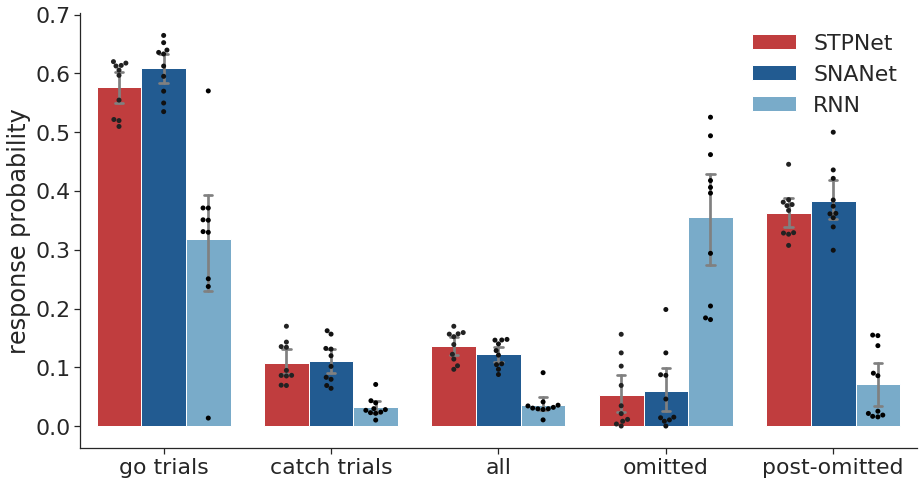

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))

sns.barplot(x='condition', y='response probability', data=df_all, hue='model', palette=[colors[0], colors[1], colors[3]], errcolor='gray', capsize=0.05)
g = sns.swarmplot(x='condition', y='response probability', data=df_all, hue='model', dodge=True, color='black')
ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[3:], labels=labels[3:], frameon=False)
# g.legend_.remove()

# Hide the right and top spines
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

In [12]:
fig.savefig('/home/a/Документы/STSPNet/compare/omitted_flash.png', dpi=300, bbox_inches='tight')